In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pickle

If mask is not generated

In [3]:
def make_zone(size):
    zone = np.zeros(shape=(size,size))
    for i in range(size):
        for j in range(size):
            zone[i,j] \
            = 1/(1 + np.e**(-((j-size/2)/(size/4))**2 - ((i-size/3)/(size/4))**2)) * (1 - 1/(1 + np.e**(-((j-size/2)/(size/4))**2 -((i-size/3)/(size/4))**2))) * 4
    return zone

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [5]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

To run automatic mask generation, provide a version of SAM 2 to the SAM2AutomaticMaskGenerator class. Set the path below to the SAM 2 checkpoint.

In [6]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [9]:
!ls /workspace/Diploma/OneActor/experiments/unicorn_with_a_coat

exp_2504192159


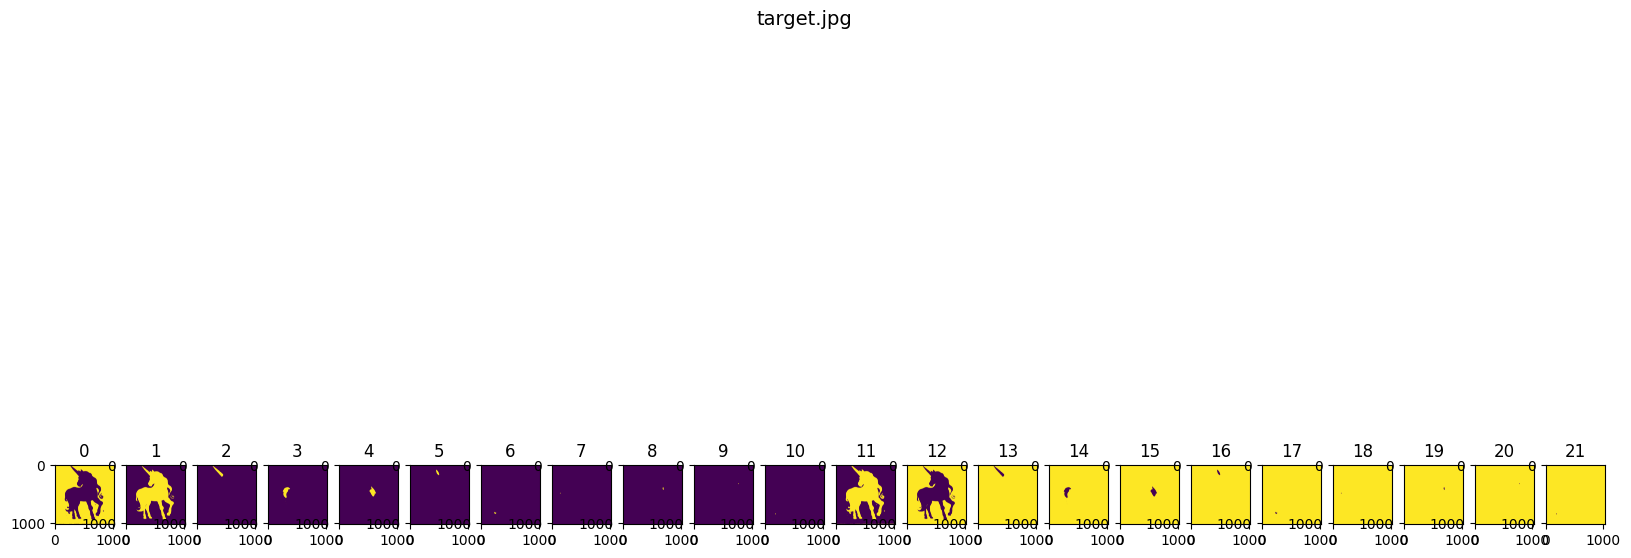

 1


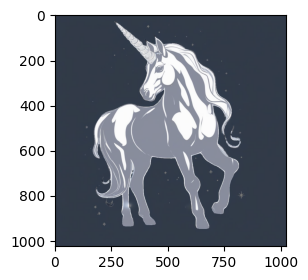

In [10]:
dir_name = "/workspace/Diploma/OneActor/experiments/unicorn_with_a_coat/exp_2504192159"

image = Image.open(f'{dir_name}/target.jpg')
image = np.array(image.convert("RGB"))
masks = mask_generator.generate(image)
_masks = [m['segmentation'] for m in masks]
_masks += [m['segmentation'] == False for m in masks]
masks = _masks
if len(masks) == 0:
    mask = Image.fromarray((make_zone(image.shape[0]) * 255.9).astype(np.uint8), 'L')
    mask.save(f"{dir_name}/base/base{n}_mask.png")
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
else:
    f, axarr = plt.subplots(1,len(masks), figsize=(20, 10))
    for n, mask in enumerate(masks):
        axarr[n].imshow(mask)
        axarr[n].set_title(str(n))
    f.suptitle("target.jpg", fontsize=14)
    plt.show()
    n_mask = int(input())
    if n_mask < 0:
        mask = Image.fromarray((make_zone(image.shape[0]) * 255.9).astype(np.uint8), 'L')
    else:    
        mask = Image.fromarray(masks[n_mask])
        
    mask.save(f'{dir_name}/target_mask.png')
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)

In [1]:
ls /workspace/OneActor/

OneActor/            metrics/           runpod_install_dream_sim.sh  sam2/
OneActor_notebooks/  prompts.txt        runpod_install_sam2.sh
README.md            read_prompt.ipynb  runpod_oneactor_install.sh
dreamsim_notebooks/  runpod_install.sh  runpod_run.sh


In [3]:
! cp ./automatic_mask_generator_example.ipynb /workspace/OneActor/sam2